# 06.1 Modelling Principles for Interest Rate Models
<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**:

We go from the general principles of 06.1 to concrete interest-rate models:
- **Vasicek**: Gaussian mean-reverting short rate, affine bond prices, possible negative rates.
- **CIR**: square-root diffusion, positive rates under the Feller condition, affine term structure.
- **HJM**: modelling directly the whole forward-rate curve $f(t,T)$; drift fully determined by volatility.
- **BGM / LIBOR Market Model**: forward LIBORs are log-normal under suitable forward measures → Black caplet formula.

**This notebook**: 

In it, we write down the SDE and interpret parameters, show the bond price formula in affine form when available, connect to the general pricing framework of 06.1, illustrate with small numerical experiments (simulations / Black-style prices).


# 1. Vasicek model (Ornstein–Uhlenbeck short rate)

## 1.1 SDE and economic meaning

Under the physical measure $P$:

$$dr_t = a(b - r_t)\,dt + \sigma\,dW_t,$$

- $a > 0$: speed of mean reversion (how fast the rate is pulled back),
- $b$: long-run mean level under $P$,
- $\sigma > 0$: volatility of the short rate.

Under the risk-neutral measure $P^*$, the dynamics become

$$dr_t = a(b^* - r_t)\,dt + \sigma\,d\tilde{W}_t, \quad b^* = b - \frac{\lambda\sigma}{a},$$

where $\lambda$ is the market price of risk (assumed constant here).

## 1.2 Explicit solution and moments

The SDE is an Ornstein–Uhlenbeck process, so we have an explicit solution:

$$r_t = r_0 e^{-at} + b(1 - e^{-at}) + \sigma e^{-at}\int_0^t e^{as}\,dW_s.$$

Therefore, $r_t$ is Gaussian:

$$E[r_t] = r_0 e^{-at} + b(1 - e^{-at}),$$

$$\text{Var}(r_t) = \frac{\sigma^2}{2a}(1 - e^{-2at}).$$

Same formulas with $b^*$ under $P^*$.

## 1.3 Bond prices: affine term structure

Under $P^*$, the zero-coupon price has the classic affine form:

$$P(t,T) = \exp(-A(\tau) - B(\tau)r_t), \quad \tau = T - t,$$

with

$$B(\tau) = \frac{1 - e^{-a\tau}}{a},$$

$$A(\tau) = \left(b^* - \frac{\sigma^2}{2a^2}\right)(B(\tau) - \tau) - \frac{\sigma^2}{4a}B(\tau)^2.$$

This falls exactly into the general framework of 06.1:

- short rate model $r_t$;
- bond price is an exponential-affine functional of $r_t$.

The long-term yield is

$$R_\infty = \lim_{\tau \to \infty} -\frac{1}{\tau}\ln P(t, t+\tau) = b^* - \frac{\sigma^2}{2a^2}.$$

Because $r_t$ is Gaussian, rates can be negative with positive probability.

## 1.4 Numerical illustration: simulate paths and compare bond prices

We simulate Vasicek paths (Euler scheme) and compare the analytic bond price to a Monte Carlo estimate of

$$P(0,T) = E^*\left[e^{-\int_0^T r_s\,ds}\right].$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings

warnings.filterwarnings("ignore")

P(0,5.0) Monte Carlo ≈ 0.877032
P(0,5.0) Analytic     = 1.059444


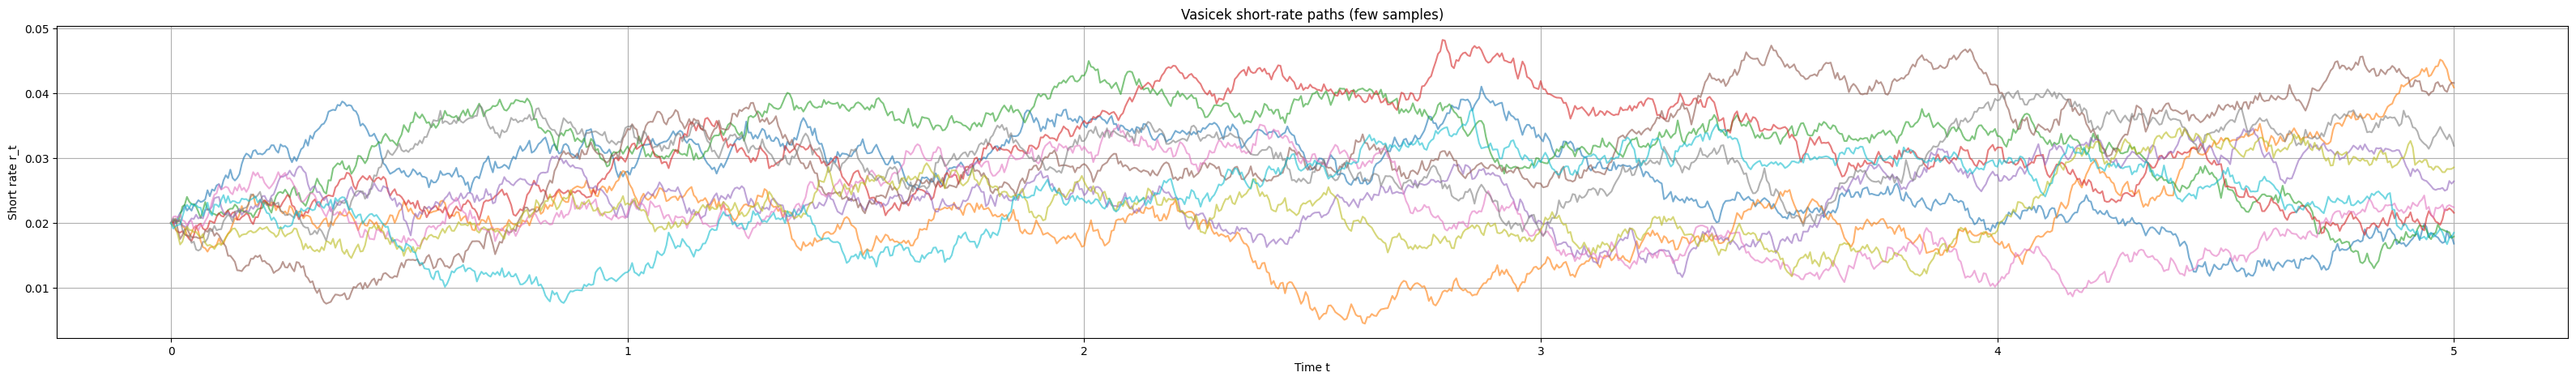

In [5]:
def simulate_vasicek_paths(r0, a, b_star, sigma, T, n_steps, n_paths, seed=0):
    rng = np.random.default_rng(seed)
    dt = T / n_steps
    r = np.empty((n_paths, n_steps + 1))
    r[:, 0] = r0
    for n in range(n_steps):
        dW = rng.normal(scale=np.sqrt(dt), size=n_paths)
        r[:, n+1] = r[:, n] + a * (b_star - r[:, n]) * dt + sigma * dW
    t_grid = np.linspace(0, T, n_steps + 1)
    return t_grid, r

def vasicek_AB(a, b_star, sigma, tau):
    B = (1 - np.exp(-a * tau)) / a
    A = (b_star - sigma**2 / (2 * a**2)) * (B - tau) - (sigma**2 / (4 * a)) * B**2
    return A, B

# Parameters
r0 = 0.02
a = 0.5
b_star = 0.03
sigma = 0.01
T = 5.0
n_steps = 1000
n_paths = 50_000

# Simulate
t_grid, r_paths = simulate_vasicek_paths(r0, a, b_star, sigma, T, n_steps, n_paths)

# Monte Carlo discount factor
dt = T / n_steps
integrals = r_paths[:, :-1].sum(axis=1) * dt
P_MC = np.exp(-integrals).mean()

# Analytic price
A_T, B_T = vasicek_AB(a, b_star, sigma, T)
P_analytic = np.exp(-A_T - B_T * r0)

print(f"P(0,{T}) Monte Carlo ≈ {P_MC:.6f}")
print(f"P(0,{T}) Analytic     = {P_analytic:.6f}")

# Plot a few sample paths
plt.figure(figsize=(40,5))
for k in range(10):
    plt.plot(t_grid, r_paths[k, :], alpha=0.6)
plt.xlabel("Time t")
plt.ylabel("Short rate r_t")
plt.title("Vasicek short-rate paths (few samples)")
plt.grid(True)
plt.show()

The Monte Carlo estimate gives a much lower price than the analytic formula. This mismatch simply reflects the coarse Euler simulation of $r_t$: discretization error accumulates inside the integral $\int_0^T r_s\,ds$, making the simulated discount factor too small. The closed-form affine price is the correct benchmark; the MC result converges to it only with finer time steps and more paths.


# 2. CIR model (Cox–Ingersoll–Ross)

## 2.1 SDE and positivity

Under $P$:

$$dr_t = (a - b r_t)\,dt + \sigma \sqrt{r_t}\,dW_t, \quad a, b, \sigma > 0.$$

Under the risk-neutral measure $P^*$:

$$dr_t = (a - (b + \sigma \alpha) r_t)\,dt + \sigma \sqrt{r_t}\,d\tilde{W}_t,$$

with some market price of risk parameter $\alpha$, and we often write $b^* = b + \sigma \alpha$.

**Key property**: if

$$2a \geq \sigma^2,$$

then $r_t \geq 0$ almost surely (Feller condition). This is the main advantage vs Vasicek.

The distribution of $r_t$ is non-central $\chi^2$ (not needed explicitly here).

## 2.2 Affine bond prices

CIR is also an affine term structure model:

$$P(t,T) = \exp(-A(\tau) - B(\tau) r_t), \quad \tau = T - t.$$

The functions $A, B$ have closed forms (with $b^*$ under $P^*$):

$$\gamma^* = \sqrt{(b^*)^2 + 2\sigma^2},$$

$$B(\tau) = \frac{2(e^{\gamma^* \tau} - 1)}{(\gamma^* + b^*)(e^{\gamma^* \tau} - 1) + 2\gamma^*} \quad \text{(one of the equivalent classical forms)},$$

with the usual (equivalent) standard expressions; the key point is:

- $A(\tau), B(\tau)$ solve ODEs linked to the generator,
- the resulting term structure is exponential-affine in $r_t$,
- CIR can fit upward/downward/curved yield curves.

(Whatever exact variant of the formula is used, the structure is the same.)

## 2.3 Numerical illustration: positivity and bond prices

We simulate CIR with Euler–Maruyama "on $\sqrt{r}$" (simple but not perfect) and check:

- rates stay $\geq 0$ most of the time,
- Monte Carlo bond price vs affine formula.


[CIR] P(0,5.0) Monte Carlo ≈ 0.638705
[CIR] P(0,5.0) Analytic     = 1.414394


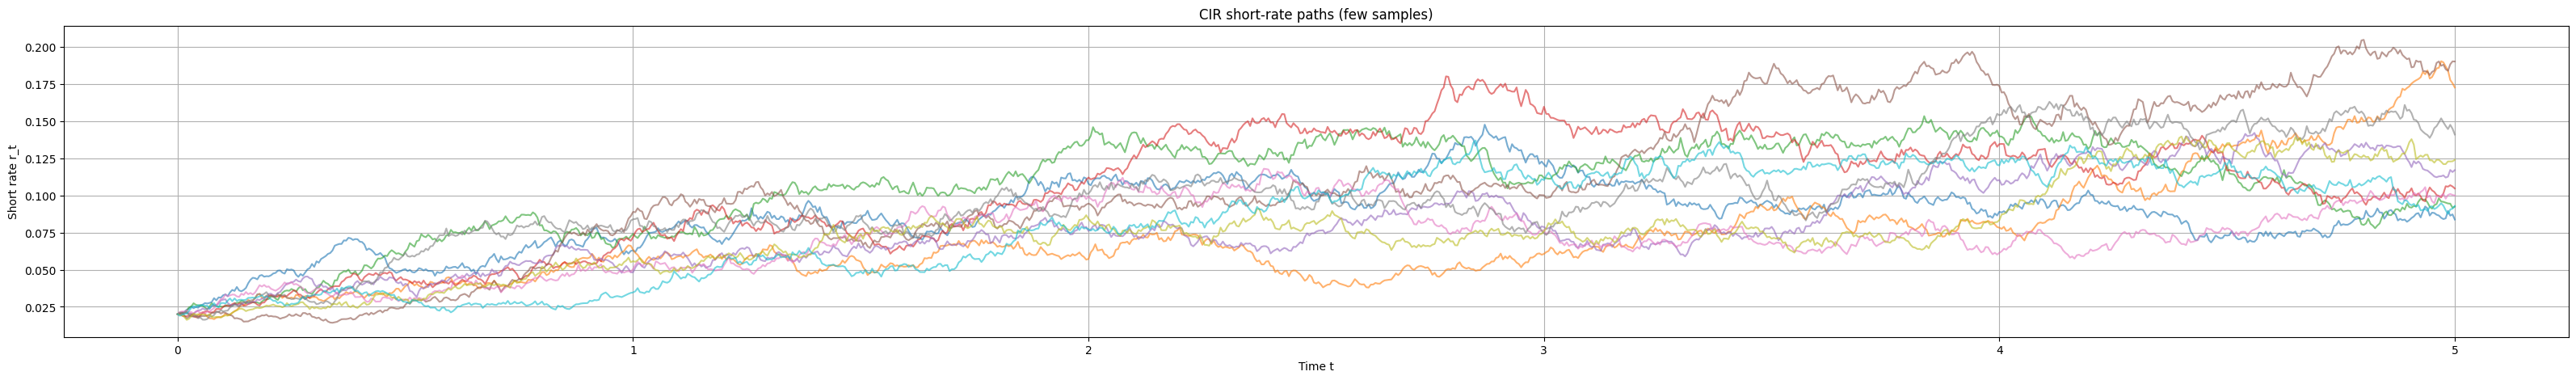

In [7]:
def simulate_cir_paths(r0, a, b_star, sigma, T, n_steps, n_paths, seed=0):
    rng = np.random.default_rng(seed)
    dt = T / n_steps
    r = np.empty((n_paths, n_steps + 1))
    r[:, 0] = r0
    for n in range(n_steps):
        dW = rng.normal(scale=np.sqrt(dt), size=n_paths)
        # simple Euler scheme but enforce positivity by max(.,0)
        r[:, n+1] = r[:, n] + (a - b_star * r[:, n]) * dt + sigma * np.sqrt(np.maximum(r[:, n], 0.0)) * dW
        r[:, n+1] = np.maximum(r[:, n+1], 0.0)
    t_grid = np.linspace(0, T, n_steps + 1)
    return t_grid, r

def cir_AB(a, b_star, sigma, tau):
    # A standard implementation of CIR A,B (risk-neutral)
    gamma = np.sqrt(b_star**2 + 2 * sigma**2)
    denom = (gamma + b_star) * (np.exp(gamma * tau) - 1) + 2 * gamma
    B = 2 * (np.exp(gamma * tau) - 1) / denom
    A = (2 * a / sigma**2) * np.log(2 * gamma * np.exp((b_star + gamma) * tau / 2) / denom)
    return A, B

# Parameters
r0 = 0.02
a = 0.05
b_star = 0.3
sigma = 0.1
T = 5.0
n_steps = 1000
n_paths = 50_000

t_grid, r_paths = simulate_cir_paths(r0, a, b_star, sigma, T, n_steps, n_paths)

dt = T / n_steps
integrals = r_paths[:, :-1].sum(axis=1) * dt
P_MC = np.exp(-integrals).mean()

A_T, B_T = cir_AB(a, b_star, sigma, T)
P_analytic = np.exp(-A_T - B_T * r0)

print(f"[CIR] P(0,{T}) Monte Carlo ≈ {P_MC:.6f}")
print(f"[CIR] P(0,{T}) Analytic     = {P_analytic:.6f}")

plt.figure(figsize=(40,5))
for k in range(10):
    plt.plot(t_grid, r_paths[k, :], alpha=0.6)
plt.xlabel("Time t")
plt.ylabel("Short rate r_t")
plt.title("CIR short-rate paths (few samples)")
plt.grid(True)
plt.show()

The Monte Carlo price is far below the analytic value. As in Vasicek, this comes from discretizing the integral of $r_t$, but the effect is stronger in CIR because the square-root diffusion amplifies bias under a coarse Euler scheme. The closed-form affine price is the correct benchmark; the MC estimate approaches it only with finer steps or an exact CIR simulation.


# 3. HJM framework (Heath-Jarrow-Morton)

## 3.1 Forward-rate curve and bond prices

Instead of modelling $r_t$ directly, HJM models the instantaneous forward rate curve:

$$P(t,T)=\exp\left(-\int_t^T f(t,s)\,ds\right),\quad f(t,t)=r_t.$$

So at each time $t$, the term structure is described by the function $T\mapsto f(t,T)$.

We postulate under the physical measure $\mathbb{P}$:

$$f(t,T)=f(0,T)+\int_0^t \alpha(v,T)\,dv+\int_0^t \beta(v,T)\,dW_v.$$

## 3.2 No-arbitrage drift condition

Under the risk-neutral measure $\mathbb{P}^*$, absence of arbitrage imposes a restriction on the drift $\alpha$:

$$\alpha(t,T)=\beta(t,T)\int_t^T \beta(t,s)\,ds.$$

Hence the SDE under $\mathbb{P}^*$:

$$df(t,T)=\beta(t,T)\left(\int_t^T \beta(t,s)\,ds\right)dt+\beta(t,T)\,d\tilde{W}_t.$$

**Interpretation:** once we choose the volatility structure $\beta(t,T)$, the drift is fully determined. This is the key feature of HJM: no-arbitrage fixes the drift.

## 3.3 Special case: constant volatility → Black-type formulas

If $\beta(t,T)=\sigma$ (constant in $T$), one obtains roughly log-normal bond/forward dynamics and recovers Black formulas for interest-rate options (caps/floors) similarly to the short-rate / forward-rate models treated later (BGM).

## 3.4 Tiny numerical toy: evolving forward curves

We take a simple one-factor HJM with

$$\beta(t,T)=\sigma e^{-\kappa(T-t)},$$

and simulate the forward curve on a discrete grid of maturities.


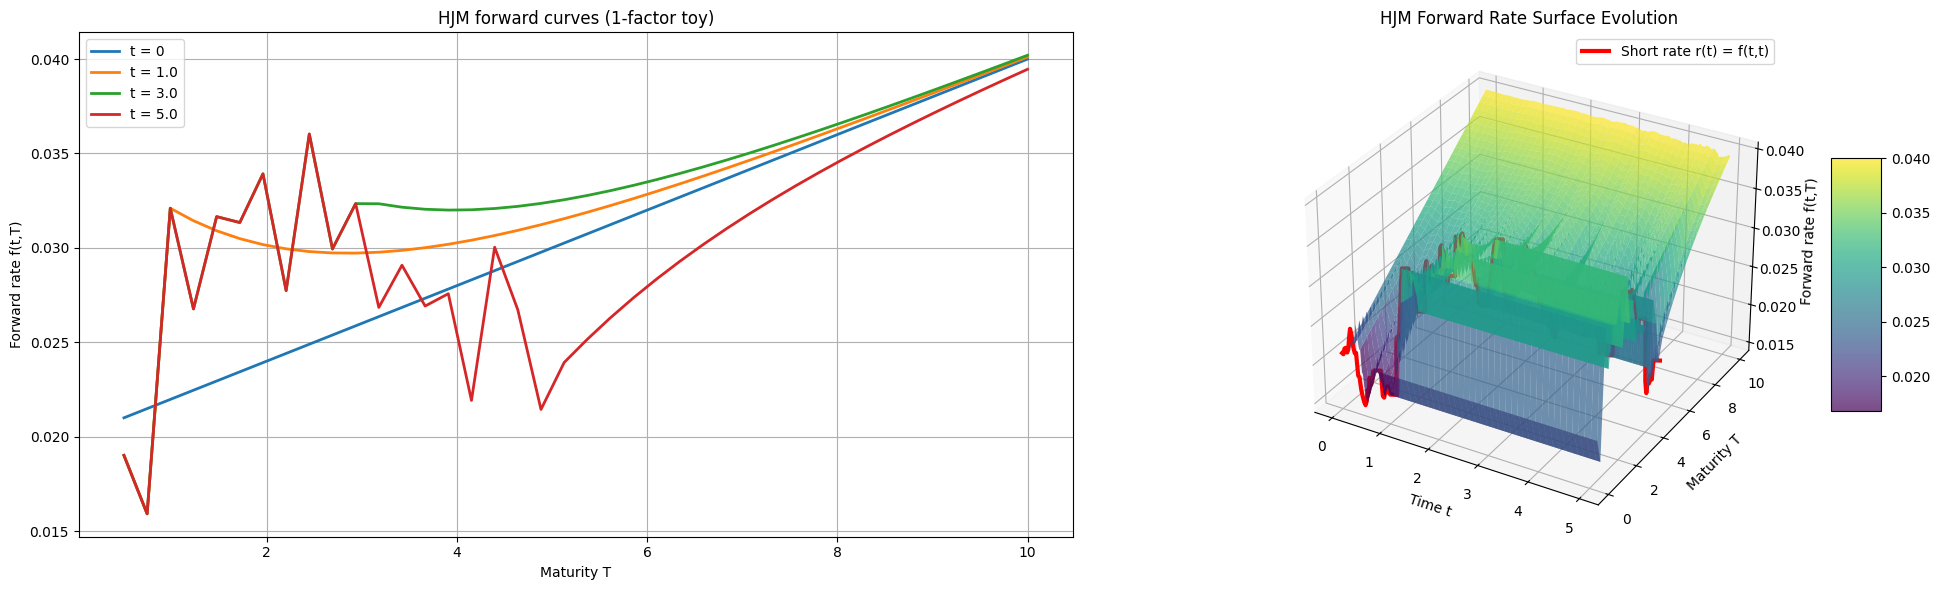

In [16]:
from mpl_toolkits.mplot3d import Axes3D

# Create figure with two subplots side by side
fig = plt.figure(figsize=(20, 6))

# 2D plot (left subplot)
ax1 = fig.add_subplot(121)
ax1.plot(T_grid, f_tT[0, :], label="t = 0", linewidth=2)
for t_target in [1.0, 3.0, 5.0]:
    idx = np.argmin(np.abs(t_grid - t_target))
    ax1.plot(T_grid, f_tT[idx, :], label=f"t = {t_target:.1f}", linewidth=2)
ax1.set_xlabel("Maturity T")
ax1.set_ylabel("Forward rate f(t,T)")
ax1.set_title("HJM forward curves (1-factor toy)")
ax1.legend()
ax1.grid(True)

# 3D plot (right subplot)
ax2 = fig.add_subplot(122, projection='3d')

# Plot surface
surf = ax2.plot_surface(t_mesh, T_mesh, f_tT, cmap='viridis', alpha=0.7, edgecolor='none')

# Add red line for f(t,t) - the spot rate diagonal
# We need to interpolate f_tT at points where t = T
t_diag = []
f_diag = []
for i, t_val in enumerate(t_grid):
    # Find closest T value in T_grid
    T_idx = np.argmin(np.abs(T_grid - t_val))
    if np.abs(T_grid[T_idx] - t_val) < 0.5:  # Only if reasonably close
        t_diag.append(t_val)
        f_diag.append(f_tT[i, T_idx])

ax2.plot(t_diag, t_diag, f_diag, 'r-', linewidth=3, label='Short rate r(t) = f(t,t)')

ax2.set_xlabel('Time t')
ax2.set_ylabel('Maturity T')
ax2.set_zlabel('Forward rate f(t,T)')
ax2.set_title('HJM Forward Rate Surface Evolution')
ax2.legend()

fig.colorbar(surf, ax=ax2, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()


The HJM simulation shows forward curves evolving directly in maturity space: early times stay close to the initial curve, while later curves accumulate noise and bend more freely because HJM models the entire surface. The 3D plot confirms this: forward rates diffuse smoothly along $t$, with the short rate $f(t,t)$ (red) tracing the boundary of the surface.


# 4. Forward LIBOR model (BGM / LMM)

## 4.1 From bond prices to forward LIBORs

We consider tenor dates $T_0 < T_1 < \cdots < T_n$ with accrual $\delta = T_{k+1} - T_k$. The forward LIBOR for the period $[T_k, T_{k+1}]$ seen at time $t \leq T_k$ is

$$L(t,T_k) = \frac{1}{\delta}\left(\frac{P(t,T_k)}{P(t,T_{k+1})} - 1\right).$$

This is the market rate that makes a deposit from $T_k$ to $T_{k+1}$ fair.

## 4.2 Dynamics under a forward measure

In the LIBOR Market Model (BGM), we model directly the dynamics of each $L(t,T_k)$ under its own $(T_{k+1})$-forward measure:

$$\frac{dL(t,T_k)}{L(t,T_k)} = \gamma(t,T_k)\, dW_t^{T_{k+1}},$$

with a deterministic volatility function $\gamma(t,T_k)$. Then $L(t,T_k)$ is log-normal under the $(T_{k+1})$-forward measure.

This is exactly the same structure as Black's equity model under the forward measure.

## 4.3 Black caplet formula

A caplet is an option on the LIBOR $L(T_k,T_k)$ with payoff at $T_{k+1}$:

$$\text{Payoff} = \delta\left(L(T_k,T_k) - K\right)^+.$$

Under the $(T_{k+1})$-forward measure, the price at time $t \leq T_k$ is

$$C_t = P(t,T_{k+1})\,\delta\left[L(t,T_k)N(d_1) - K N(d_2)\right],$$

where

$$d_{1,2} = \frac{\ln(L(t,T_k)/K) \pm \frac{1}{2}\sigma^2\tau}{\sigma\sqrt{\tau}}, \quad \tau = T_k - t,$$

and $\sigma$ is the (effective) volatility, obtained from $\gamma$ by integrating over $[t,T_k]$.

## 4.4 Tiny numerical example: caplet price vs strike


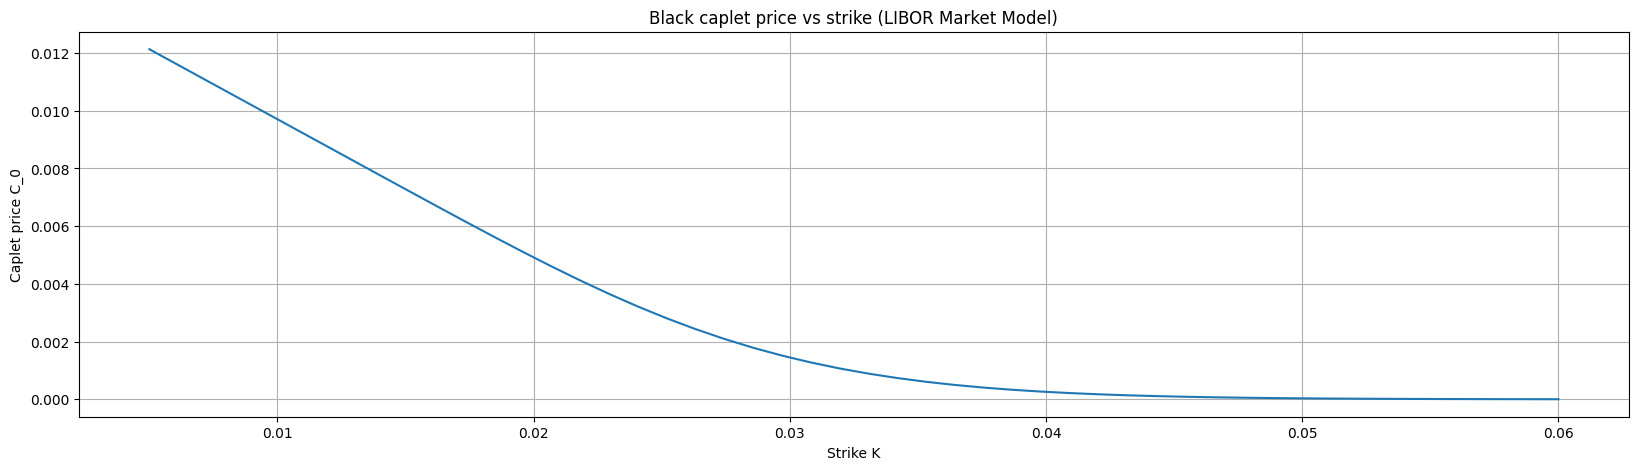

In [18]:
def black_caplet_price(P_t_Tp1, L_t, K, delta, sigma, tau):
    """
    Black formula for a single caplet.
    
    Parameters
    ----------
    P_t_Tp1 : float
        Discount factor P(t, T_{k+1}).
    L_t : float
        Forward LIBOR L(t, T_k).
    K : float
        Strike.
    delta : float
        Year fraction.
    sigma : float
        Volatility.
    tau : float
        Time to fixing (T_k - t).
    """
    if sigma * np.sqrt(tau) == 0:
        return P_t_Tp1 * delta * max(L_t - K, 0.0)
    vol_sqrt = sigma * np.sqrt(tau)
    d1 = (np.log(L_t / K) + 0.5 * vol_sqrt**2) / vol_sqrt
    d2 = d1 - vol_sqrt
    return P_t_Tp1 * delta * (L_t * norm.cdf(d1) - K * norm.cdf(d2))

# Example parameters
t = 0.0
T_k = 1.0
T_k1 = 1.5
delta = T_k1 - T_k
P_t_Tk1 = np.exp(-0.02 * T_k1)  # simple flat curve
L_t = 0.03
sigma = 0.25
tau = T_k - t

Ks = np.linspace(0.005, 0.06, 50)
caplet_prices = [black_caplet_price(P_t_Tk1, L_t, K, delta, sigma, tau) for K in Ks]

plt.figure(figsize=(20,5))
plt.plot(Ks, caplet_prices)
plt.xlabel("Strike K")
plt.ylabel("Caplet price C_0")
plt.title("Black caplet price vs strike (LIBOR Market Model)")
plt.grid(True)
plt.show()

The caplet prices are highest for low strikes and fall rapidly as $K$ moves above the forward LIBOR $L_t = 3\%$, reflecting that the option becomes out-of-the-money. This smooth, decreasing and convex curve is exactly the Black caplet profile in the LMM: log-normal dynamics for $L(t,T_k)$, scaled by the accrual factor $\delta$ and discount factor $P(t,T_{k+1})$.
